A simple example where the XCS shall learn the n-bit Multiplexer. This is a single step problem.
The example below uses the 6-bit multiplexer.
Given an input X = [n_0, ..., n_5] the output should be 0 or 1. The first two bits of X, that is n_0, n_1, serve as
address pointing to one of the remaining bits of X. For example given the input X = [0,1,1,0,1,0] the first two bits
form the binary number '01'. So the output should be X[offset + '01'] = X[2 + 1] = X[3] =  0,
where offset = 2 because we use two bits for the address.

In [1]:
import random
import sys
from typing import List

from xcsframework.xcs import *
from xcsframework.training import *

In [2]:
class MultiplexerEnvironment(IEnvironment):
    """
    Encapsulates the Multiplexer problem in an environment.
    """

    def __init__(self, length: int, reward: Number):
        self._length = length
        self._address_length = self._get_adress_length(length, 0)
        self._reward = reward
        self._current_state = None

        # length has to be n + 2^n
        assert self._length == self._address_length + (1 << self._address_length)

    def get_state(self) -> State[int]:
        """
        Generates a random state filled with '0' and '1'.
        """
        s = [None] * self._length
        for i in range(self._length):
            s[i] = 0 if random.random() < 0.5 else 1
        self._current_state = State(s)
        return self._current_state

    def get_available_actions(self) -> List[int]:
        return [0, 1]

    def execute_action(self, action: int) -> Number:
        expected = self._get_expected_action(self._current_state)
        return self._reward if expected == action else 0

    def is_end_of_problem(self) -> bool:
        """
        :return: Always true on single step problems.
        """
        return True

    def _get_expected_action(self, state) -> int:
        """
        :return: n-bit Multiplexer applied to the state.
        """
        address = int(f"{state[0]}{state[1]}", 2)
        return state[self._address_length + address]

    def _get_adress_length(self, l: int, c: int):
        return c - 1 if l == 0 else self._get_adress_length(l >> 1, c + 1)

In [3]:
# some helper methods

def validate(xcs, environment, metrics, iterations):
    predictions = [None] * iterations
    actual = [None] * iterations
    metric_scores = []

    for i in range(iterations):
        state = environment.get_state()
        predictions[i] = xcs.query(state)
        actual[i] = environment._get_expected_action(state)
        environment.execute_action(predictions[i])

    for metric in metrics:
        metric_scores.append((str(metric), metric.score(predictions, actual)))

    return metric_scores

def print_population(population, amount: int = 0):
    """
    Prints a population.
    """
    sorted_population = sorted(population, key=lambda cl: -cl.experience)
    txt = ""
    if 0 < amount < population.numerosity_sum():
        txt = f" (showing {amount} most experienced classifier)"
    print(f"\nPopulation with size: {population.numerosity_sum()} {txt} :")
    for i, cl in enumerate(sorted_population):
        if 0 < amount < i:
            break
        print(f"   {cl}")

# Parameters

## Problem parameters

In [4]:
# the length of the input. larger inputs lead to increased runtime and complexity
INPUT_LENGTH = 6

## Training parameters

In [5]:
# after how many training iterations validation will be done
BATCH_SIZE = 10

# how many epochs will be done. total iterations = epochs * batch_size
EPOCHS = 500

# size of validation data
VALIDATION_SIZE = 50

# size of the Test Set
TESTING_SIZE = 1000

# the reward received for correct classification
MAX_REWARD = 100

# XCS parameters

In [6]:
# error threshold under which a classifier is considered to be accurate in its prediction
EPSILON_ZERO = MAX_REWARD / 100

# maximum classifier count
POPULATION_SIZE = 300

# a bit higher than the default
LEARNING_RATE = 0.3

# probability for a symbol to turn into a wildcard
WILDCARD_PROBABILITY = 0.4

# fitness parameter for updating values
FITNESS_ALPHA = 0.3

# Initialization

## Instantiate constants

In [7]:
# 1. creating the environment
environment = MultiplexerEnvironment(INPUT_LENGTH, MAX_REWARD)

# 2. instantiating constants (hyper parameters) and customizing values
# we only instantiate those constants of which we use different values than default
learning_constants = LearningConstants(epsilon_zero=EPSILON_ZERO)
fitness_constants = FitnessConstants(alpha=FITNESS_ALPHA)
covering_constants = CoveringConstants(wild_card_probability=WILDCARD_PROBABILITY)

## Assemble XCS components

In [8]:
# 3. creating xcs components
covering_component = CoveringComponent(covering_constants=covering_constants)
learning_component = QLearningBasedComponent(learning_constants=learning_constants,
                                             fitness_constants=fitness_constants)
discovery_component = GeneticAlgorithm(available_actions=environment.get_available_actions())
performance_component = PerformanceComponent(min_diff_actions=len(environment.get_available_actions()),
                                             covering_component=covering_component,
                                             available_actions=environment.get_available_actions())

subsumption_criteria = SubsumptionCriteriaExperiencePrecision(max_epsilon=EPSILON_ZERO)

## Initialize empty population

In [9]:
# 4. initialize empty population
population = Population(max_size=POPULATION_SIZE,
                        subsumption_criteria=subsumption_criteria)

## Initialize XCS

In [10]:
xcs: XCS[int, int] = XCS(population=population,
                         performance_component=performance_component,
                         discovery_component=discovery_component,
                         learning_component=learning_component,
                         available_actions=environment.get_available_actions())

# Training

In [11]:
# 5.training
trainer = TrainerEnvironment()
accuracy_metric = Accuracy()
metric_history = []

print(f"Starting to learn the {INPUT_LENGTH}-bit Multiplexer...")

for epoch in range(EPOCHS):
    trainer.optimize(xcs=xcs, environment=environment, training_iterations=BATCH_SIZE)
    # validation
    metric_scores_epoch = validate(xcs, environment, [accuracy_metric], VALIDATION_SIZE)
    metric_history.append(metric_scores_epoch)
    sys.stdout.write(f"\rEpoch {epoch + 1}/{EPOCHS} --- Metrics: {metric_scores_epoch}")

Starting to learn the 6-bit Multiplexer...
Epoch 500/500 --- Metrics: [('Accuracy', 0.98)]

In [12]:
# output the population
print_population(xcs.population, 20)


Population with size: 300  (showing 20 most experienced classifier) :
   [#|#|1|1|#|#] --> 1, F:0.278, P:83.334, E:30.370, N:8, exp:877, AS:16.284
   [#|0|#|#|1|#] --> 1, F:0.625, P:83.756, E:21.473, N:8, exp:409, AS:15.174
   [#|1|#|0|#|0] --> 0, F:0.698, P:100.000, E:0.000, N:12, exp:352, AS:21.567
   [1|1|#|#|#|0] --> 0, F:0.542, P:100.000, E:0.000, N:10, exp:339, AS:20.528
   [0|1|#|1|#|#] --> 1, F:0.820, P:100.000, E:0.000, N:13, exp:331, AS:27.990
   [0|#|#|0|#|#] --> 0, F:0.156, P:85.758, E:30.363, N:8, exp:316, AS:21.710
   [#|1|#|#|#|1] --> 1, F:0.363, P:86.627, E:21.825, N:4, exp:178, AS:18.699
   [#|0|0|#|#|#] --> 0, F:0.379, P:94.572, E:14.179, N:7, exp:139, AS:18.362
   [0|#|1|1|#|#] --> 0, F:0.658, P:0.000, E:0.000, N:17, exp:130, AS:27.735
   [1|0|#|#|0|#] --> 1, F:0.794, P:0.000, E:0.000, N:12, exp:130, AS:25.059
   [1|0|#|#|1|#] --> 0, F:0.966, P:0.000, E:0.000, N:15, exp:125, AS:24.680
   [0|1|#|1|#|#] --> 0, F:0.803, P:0.000, E:0.000, N:18, exp:124, AS:24.392
   [1|

# Testing

In [13]:
# 6. testing
test_accuracy = validate(xcs, environment, [accuracy_metric], TESTING_SIZE)

print(f"\nTesting Accuracy: {test_accuracy[0]} on {TESTING_SIZE} samples.")


Testing Accuracy: ('Accuracy', 0.963) on 1000 samples.


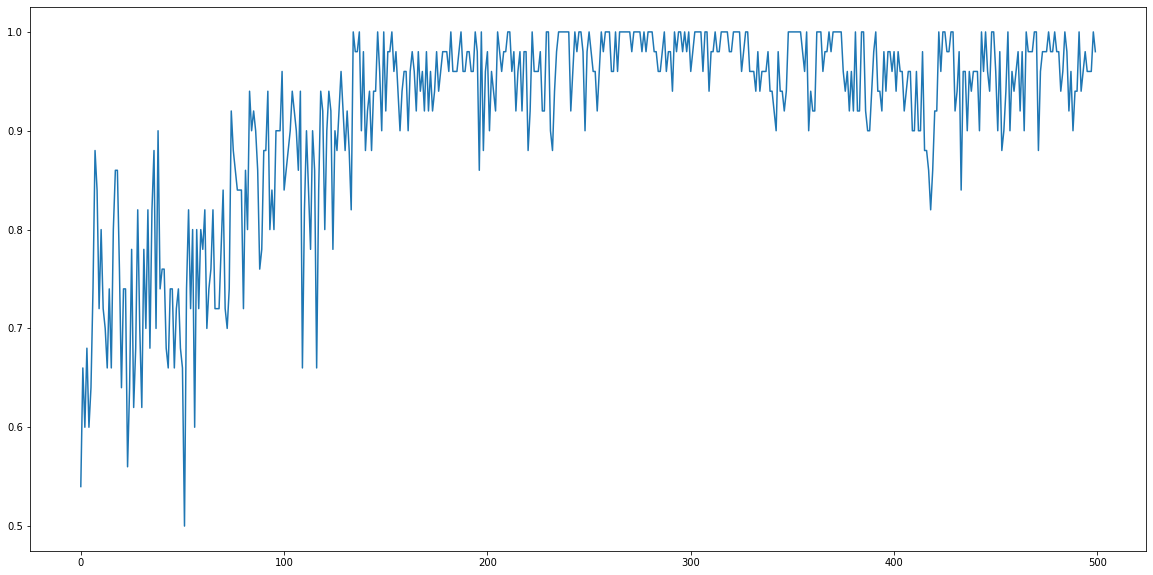

In [14]:
import matplotlib.pyplot as plt

accuracy_history = [metric[0][1] for metric in metric_history]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(accuracy_history)